In [1]:
import os
from pathlib import Path
from typing import List, Optional
from collections import defaultdict


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Hack the system path a little bit so we can import ..scripts.utils
import sys
sys.path.append('..')

from scripts import utils

/Users/thomasliao/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thomasliao/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thomasliao/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thomasliao/.local/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
OUTPUT_DIR = Path("../output")
DATA_DIR = Path("../data")

# Helper functions

In [3]:
# Path functions
def get_subdirs(d: Path) -> List[Path]:
    return [f for f in d.iterdir() if f.is_dir()]

def get_exp_paths(exp_name: str, *, most_recent=False) -> List[Path]:
    paths = DATA_DIR.glob(f"*{exp_name}*")
    paths = list(sorted(paths, key=os.path.getmtime, reverse=True))
    paths = [p for p in paths if 'bl' not in str(p)]
    if most_recent:
        return [paths[0]]
    return paths

In [4]:
# Log functions

# https://github.com/franklinfrank/285project/blob/diff_ac/cs285/infrastructure/rl_trainer.py#L278-L301
def parse_tf_eventsfile(filename: str, *, tag='Eval_AverageReturn') -> List:
    eval_returns = []
    for e in tf.train.summary_iterator(filename):
        for v in e.summary.value:
            if v.tag == tag:
                eval_returns.append(v.simple_value)

    return eval_returns

# Plotting Code

In [30]:
DEFAULT_FIGSIZE = (10,8)

TEXT_SIZE_SML = 12
TEXT_SIZE_MED = 18
TEXT_SIZE_LRG = 25

FREE_VARIABLES = {
    'env_sweep': 'env_name', 
    'sample_sweep': 'sample_strategy',
    'terminal_val_sweep': 'terminal_val',
    'batch_size_sweep': 'batch_size'
}

PRETTY_TITLES = {
    'env_sweep': 'Comparison of methods on {env_name}', 
    'sample_sweep': 'Different sample strategies on {env_name}',
    'terminal_val_sweep': 'Different terminal values on {env_name}',
    'batch_size_sweep': 'Different batch size on {env_name}'
}

# BASELINES[env_name][seed]
BASELINES = {
    'CartPole-v0': {
        2020: 'ac_bl_seed=2020_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50',
        2: 'ac_bl_seed=2_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50'
        
    },
    'HalfCheetah-v2': {
        2020: 'ac_bl_seed=2020_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-49',
        2: 'ac_bl_seed=2_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-50'
    },
    'InvertedPendulum-v2': {
        2020: 'ac_bl_seed=2020_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50',
        2: 'ac_bl_seed=2_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50'
    }
}

In [35]:
def plot_exp_set(exp_set_name: str, *, plot_baseline=False) -> None:
    """ Always averages over seeds
    """ 
    
    # Create a figure for each environment
    for i, env_name in enumerate(utils.environments):
        title = PRETTY_TITLES[exp_set_name].format(env_name=env_name)
        plt.figure(i, figsize=DEFAULT_FIGSIZE)
        plt.title(title)
    
    logfiles = defaultdict(lambda: defaultdict(list))
    tmp = utils.get_exp_flags(exp_set_name)
    for exp_flags in tmp:
        # Get the run_folder for this combination of experiment flags
        exp_name = utils.get_exp_name(exp_flags)
        run_folder = get_exp_paths(exp_name, most_recent=True)[0]
        # Identify the logfile
        logfile = str(list(run_folder.iterdir())[0])
        
        # Average over seed, so get a exp_name that excludes the seed
        exp_label = exp_flags[FREE_VARIABLES[exp_set_name]] if exp_set_name is not "env_sweep" else "Differential"
        logfiles[exp_flags['env_name']][exp_label].append(logfile)
    
    ys_to_plot = []
    # Average over seed
    for env_name, trials in logfiles.items():
        for label, files in trials.items():
            # Aggregate things
            trial_ys = []
            for logfile in files:
                trial_ys.append(parse_tf_eventsfile(logfile))
            trial_ys = np.array(trial_ys)
            
            y_min = np.min(trial_ys, axis=0)
            y_avg = np.average(trial_ys, axis=0)
            y_max = np.max(trial_ys, axis=0)
            std = np.std(trial_ys, axis=0, ddof=1)
            y_lower = y_avg - std
            y_upper = y_avg + std
            xs = range(y_avg.shape[0])
            
            # Get the correct figure
            plt.figure(utils.environments.index(env_name))
            plt.plot(y_avg, label=label)
            plt.fill_between(xs, y_lower, y_upper, alpha=.2)
            plt.fill_between(xs, y_lower, y_upper, alpha=.2)
            
            # Plot baselines
            if plot_baseline:
                bl_ys = []
                for seed, log_folder in BASELINES[env_name].items():
                    log_folder = DATA_DIR / log_folder
                    logfile = str(list(log_folder.iterdir())[0])
                    bl_ys.append(parse_tf_eventsfile(logfile))
                bl_ys = np.array(bl_ys)
                
                bl_ys_min = np.min(bl_ys, axis=0)
                bl_ys_avg = np.average(bl_ys, axis=0)
                bl_ys_max = np.max(bl_ys, axis=0)
                bl_std = np.std(bl_ys, axis=0, ddof=1)
                bl_y_lower = bl_ys_avg - std
                bl_y_upper = bl_ys_avg + std
                xs = range(bl_ys_avg.shape[0])
                
                plt.plot(bl_ys_avg, label='Baseline')
                plt.fill_between(xs, bl_y_lower, bl_y_upper, alpha=.2)
            
            plt.legend()
            
    for i, env_name in enumerate(utils.environments):
        plt.figure(i)
        title = f"{exp_set_name}__on__{env_name}"
        plt.savefig(OUTPUT_DIR / title)
    
    plt.show()

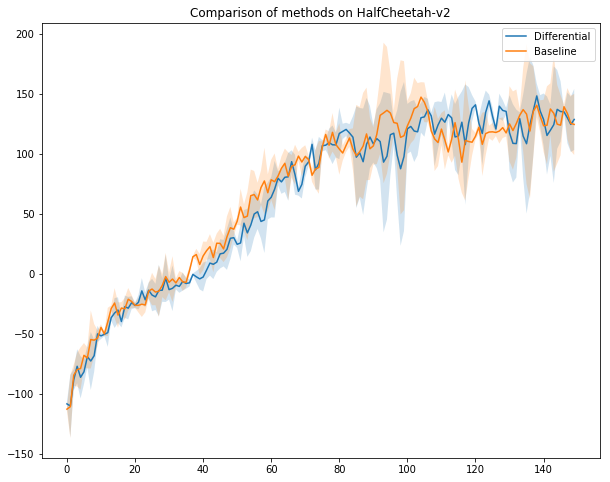

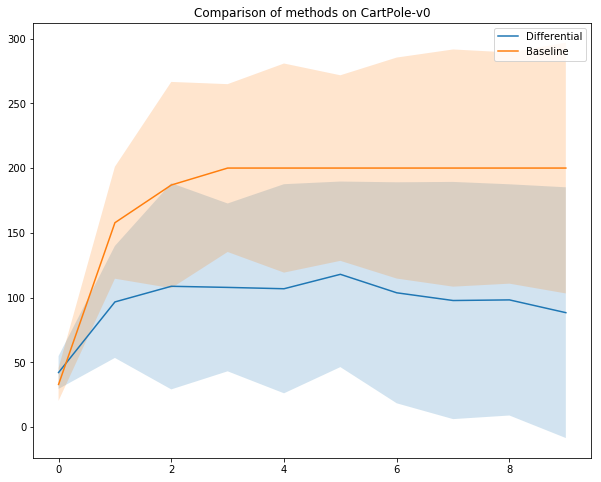

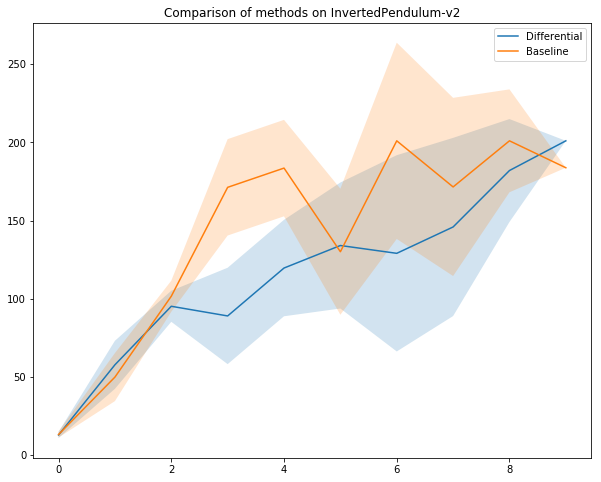

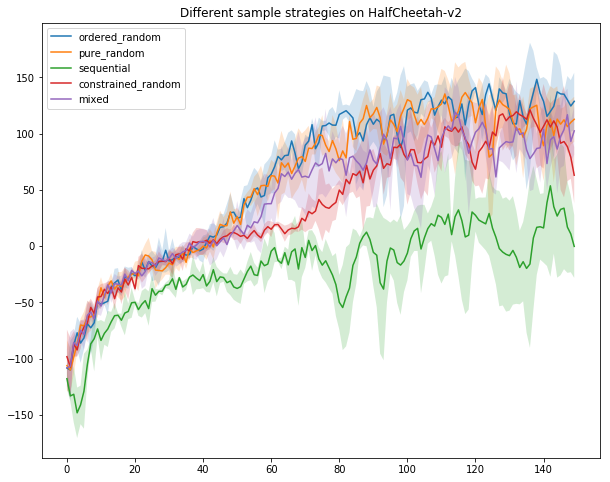

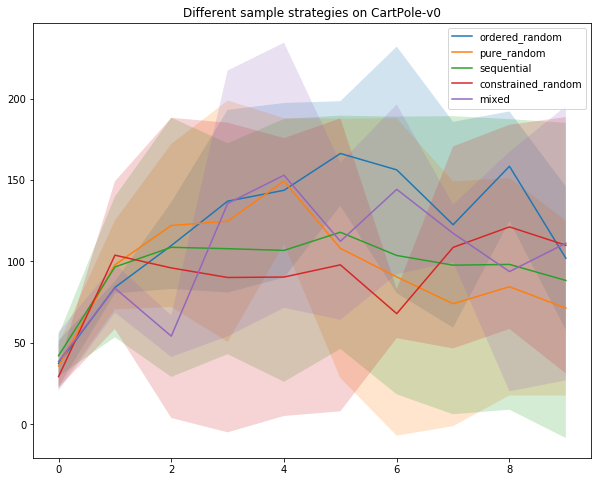

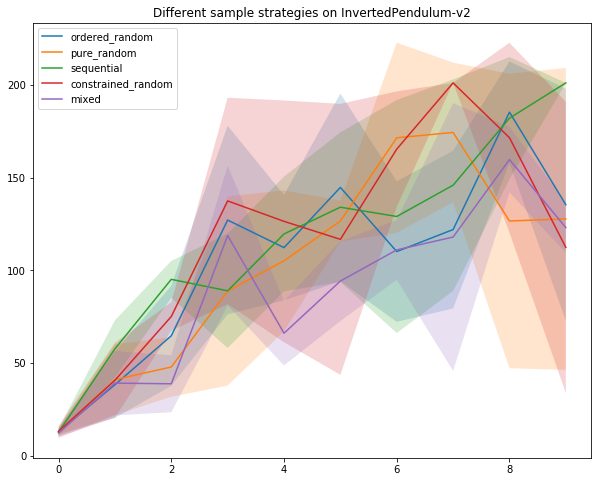

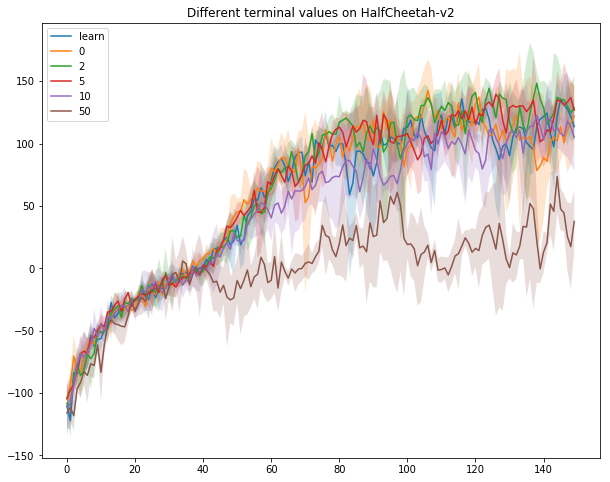

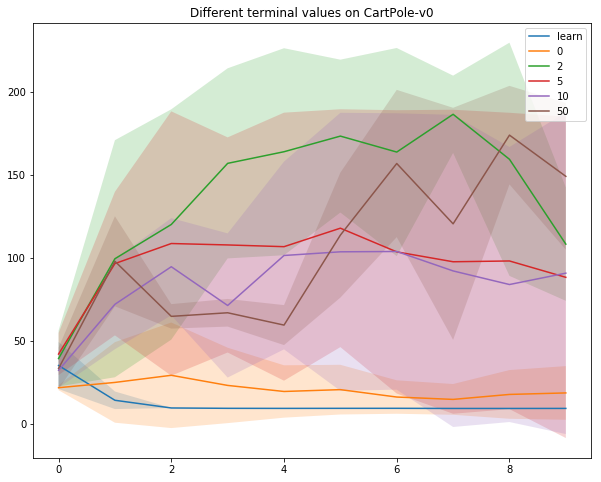

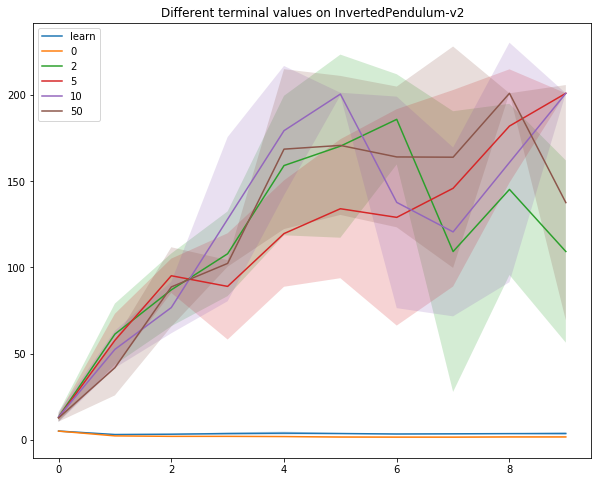

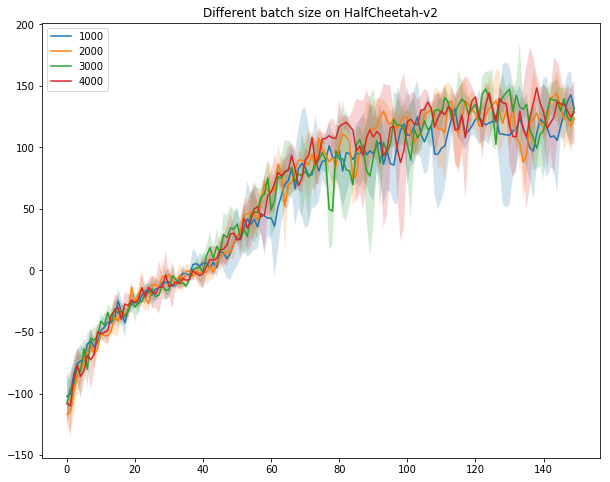

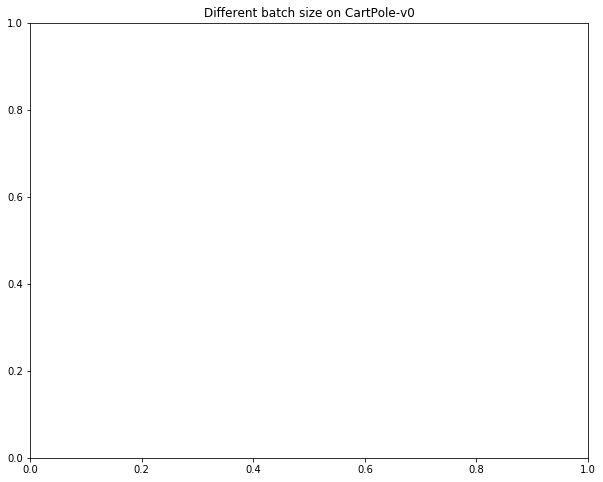

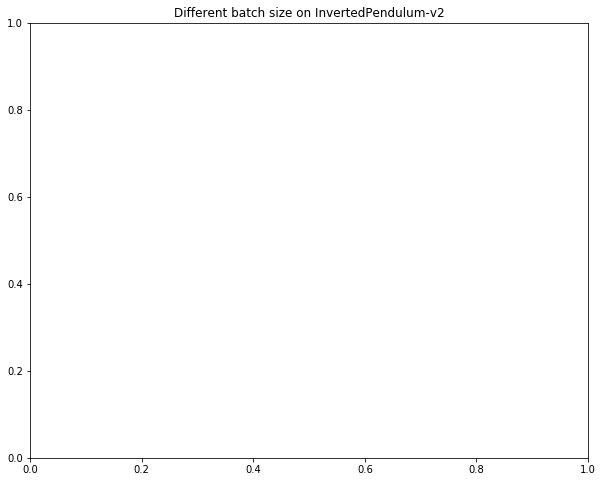

In [36]:
plot_exp_set('env_sweep', plot_baseline=True)
plot_exp_set('sample_sweep')
plot_exp_set('terminal_val_sweep')
plot_exp_set('batch_size_sweep')